## 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import joblib
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 导入数据

In [2]:
train=pd.read_csv(r"D:\jupyter name\数据\train.csv")
test=pd.read_csv(r"D:\jupyter name\数据\test.csv")
train.shape,test.shape

((593994, 13), (254569, 12))

In [3]:
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


## 对数据进行处理

In [4]:
X=train.drop(['id','loan_paid_back'],axis=1)
y=train['loan_paid_back']
test=test.drop('id',axis=1)

## 特征类型划分

In [5]:
cat_feature=[col for col in X.columns if X[col].dtype=='object']
num_feature=[col for col in X.columns if X[col].dtype in['int64','float64'] and col !='id']

## 特征工程

In [6]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=42)
preprocessor=ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),num_feature),
        ('cat',OneHotEncoder(handle_unknown='ignore'),cat_feature)
    ]
)

## 模型构建与优化

In [7]:
models={
    '逻辑回归':LogisticRegression(max_iter=1000,random_state=42),
    '随机森林':RandomForestClassifier(),
    'XGBoost':XGBClassifier()
}
model_performance={}
for name,model in models.items():
    pipeline=Pipeline(steps=[('preprocessor',preprocessor),
                            ('model',model)])
    pipeline.fit(X_train,y_train)
    pred=pipeline.predict_proba(X_valid)[:,1]
    auc=roc_auc_score(y_valid,pred)
    model_performance[name] = {"auc": auc, "pipeline": pipeline}

In [8]:
model_performance

{'逻辑回归': {'auc': 0.9113364141158209,
  'pipeline': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num', StandardScaler(),
                                                    ['annual_income',
                                                     'debt_to_income_ratio',
                                                     'credit_score',
                                                     'loan_amount',
                                                     'interest_rate']),
                                                   ('cat',
                                                    OneHotEncoder(handle_unknown='ignore'),
                                                    ['gender', 'marital_status',
                                                     'education_level',
                                                     'employment_status',
                                                     'loan_purpose',
                                    

在这三个模型中，xgboost表现最好

## 对Xgboost进行超参数调优

In [9]:
param_grid={
    'model__n_estimators':[300,500],  
    'model__max_depth':[3,5,7],
    'model__learning_rate':[0.01,0.1]
}
search=RandomizedSearchCV(
    estimator=model_performance['XGBoost']['pipeline'],
    param_distributions=param_grid,  
    cv=3,
    n_jobs=-1,
    scoring='roc_auc'
)
search.fit(X_train,y_train)
best_model=search.best_estimator_
best_auc=search.best_score_

In [10]:
best_auc

np.float64(0.9205754794751458)

进行超参数调优得到的ruc值没有默认得到的高，所以我们选择XGBoost来进行预测

通过AI助手的帮助，我们可以得到xgboost模型的roc曲线

=== 最优模型详细评估 ===
              precision    recall  f1-score   support

         已偿还       0.88      0.61      0.72     23997
         未偿还       0.91      0.98      0.94     94802

    accuracy                           0.90    118799
   macro avg       0.90      0.79      0.83    118799
weighted avg       0.90      0.90      0.90    118799



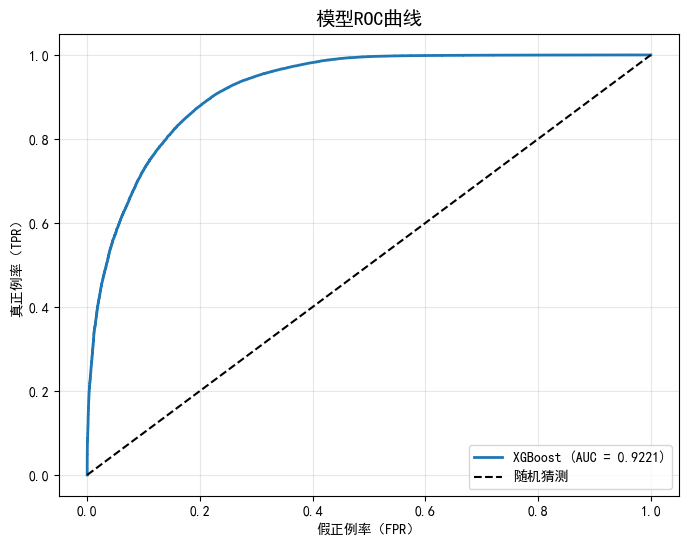

In [11]:
# 1. 详细评估指标
y_val_pred = best_model.predict(X_valid)
print("=== 最优模型详细评估 ===")
print(classification_report(y_valid, y_val_pred, target_names=["已偿还", "未偿还"]))

# 2. 绘制ROC曲线
plt.figure(figsize=(8, 6))
y_val_prob = best_model.predict_proba(X_valid)[:, 1]
fpr, tpr, _ = roc_curve(y_valid, y_val_prob)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_score(y_valid, y_val_prob):.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="随机猜测")
plt.xlabel("假正例率（FPR）")
plt.ylabel("真正例率（TPR）")
plt.title("模型ROC曲线", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



## 预测输出结果，并生成文件

In [12]:
pipeline=Pipeline(steps=[('preprocessor',preprocessor),
                            ('model',XGBClassifier())])
pipeline.fit(X_train,y_train)
test_pred=pipeline.predict_proba(test)[:,1]

In [13]:
data=[]
for i in range(len(test)):
    data.append((len(train)+i,test_pred[i]))

In [14]:
data=pd.DataFrame(data,columns=['id','loan_paid_back'])

In [15]:
data.to_csv('loan_predict.csv',index=False,sep=',',encoding='utf-8')